In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
uni_data_df = pd.read_csv('../nba_forecast/data/last_ncaa_season.csv')

<AxesSubplot:xlabel='mp', ylabel='Count'>

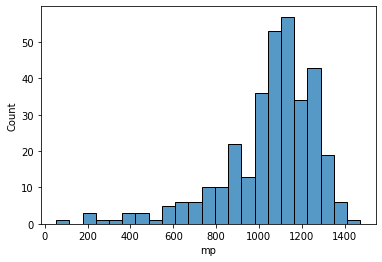

In [3]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.histplot(uni_data_df['mp'])


In [4]:
df_explo = uni_data_df.drop(columns=['school_name','conf_abbr','player_id','player_name', 'season'])

In [5]:
scaler = StandardScaler()
scaler.fit(df_explo[['mp']]) # Fit scaler to data

df_explo['mp'] = scaler.transform(df_explo[['mp']]) # Use scaler to transform data
df_explo.head()

,g,gs,mp,per,ts_pct,efg_pct,fg3a_per_fga_pct,fta_per_fga_pct,pprod,orb_pct,...,tov_pct,usg_pct,ows,dws,ws,ws_per_40,obpm,dbpm,bpm,years
0,40,40,1.028759,35.1,0.654,0.628,0.059,0.602,550.0,11.6,...,8.6,18.8,5.9,4.1,9.9,0.310,9.1,8.1,17.2,1
1,40,39,0.869182,21.2,0.570,0.511,0.156,0.589,497.0,10.3,...,17.3,20.6,3.4,2.6,6.0,0.192,4.1,3.6,7.7,1
2,37,37,0.966701,22.0,0.575,0.525,0.473,0.440,522.0,4.8,...,14.3,23.0,3.6,2.1,5.7,0.180,5.4,2.9,8.4,1
3,37,0,-0.699996,26.3,0.565,0.534,0.317,0.331,430.0,2.4,...,10.4,26.7,3.2,1.7,5.0,0.223,6.0,4.8,10.8,2
4,39,39,0.855883,27.4,0.549,0.512,0.027,0.462,660.0,11.1,...,14.2,30.0,3.7,3.5,7.2,0.231,5.4,3.4,8.8,3


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_explo.columns

In [7]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_explo.values, i)
                          for i in range(len(df_explo.columns))]
  
vif_data.sort_values(by='VIF',ascending=False)

,feature,VIF
23,bpm,34652.529693
21,obpm,15487.943900
19,ws,12642.075674
17,ows,5263.816235
22,dbpm,5155.168823
11,trb_pct,4114.354438
4,ts_pct,2583.725482
10,drb_pct,2083.105529
3,per,1791.244522
18,dws,1688.622099


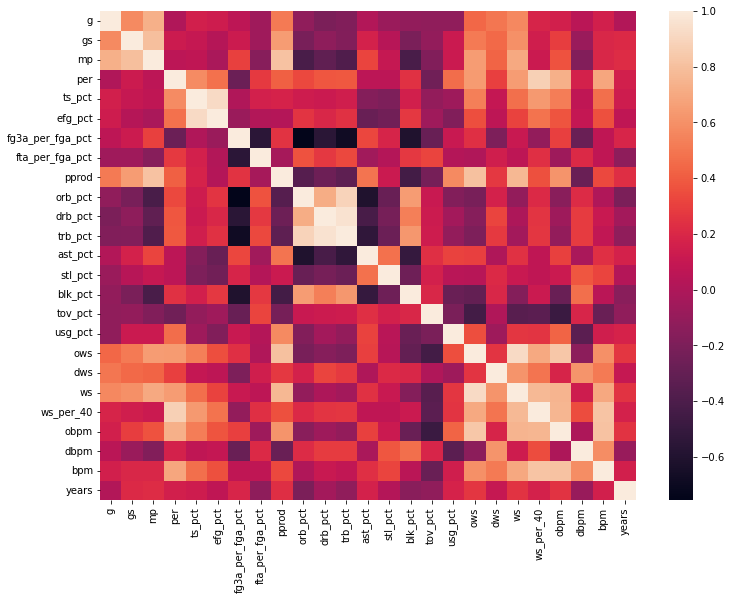

In [8]:
a4_dims = (12, 9)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_explo.corr());

## Baseline model

Le baseline modèle prédira la valeur moyenne de tous les ratios, peu importe les statistiques du joueur que l'on étudie.

In [9]:
ratio_df = pd.read_csv('../nba_forecast/data/player_ratio_scores.csv')

In [61]:
ratio_df

,player_id,player_name,pos,off_score,def_score,uni_off_score,uni_def_score,ratio_off,ratio_def
0,anthony-davis-5,Anthony Davis,PF,3.96,3.34,3.68,3.79,1.08,0.88
1,michael-kidd-gilchrist-1,Michael Kidd-Gilchrist,SF,2.68,1.89,2.73,1.96,0.98,0.96
2,bradley-beal-1,Bradley Beal,SG,2.73,1.71,2.93,1.99,0.93,0.86
3,dion-waiters-1,Dion Waiters,SG,2.36,1.49,2.97,2.04,0.79,0.73
4,thomas-robinson-2,Thomas Robinson,PF,2.68,2.17,3.03,2.67,0.88,0.81
...,...,...,...,...,...,...,...,...,...
329,devon-hall-1,Devon Hall,NaN,NaN,NaN,2.93,1.77,NaN,NaN
330,raymond-spalding-1,Raymond Spalding,NaN,NaN,NaN,2.71,2.56,NaN,NaN
331,kevin-hervey-1,Kevin Hervey,NaN,NaN,NaN,3.05,1.66,NaN,NaN
332,thomas-welsh-1,Thomas Welsh,NaN,NaN,NaN,2.75,1.65,NaN,NaN


On ne retient pas les données des joueurs qui n'ont pas effectué au moins 3 saisons en NBA. Ces derniers feront l'objet d'une étude parallèle où l'on tentera de clusteriser les joueurs susceptibles ou non de rester en NBA au moins 3 ans.

In [10]:
all_data_df = pd.merge(
                uni_data_df,
                ratio_df,
                how="inner",
                on='player_id')

all_data_df = all_data_df[all_data_df['ratio_off'].notna()]

In [11]:
X = all_data_df.drop(columns=[
    'player_name_x','player_name_y', 'player_id',
    'ws','ws_per_40','bpm','off_score', 'def_score', 
    'uni_off_score', 'uni_def_score', 'ratio_off','ratio_def']
                        )
X = X.reset_index().drop(columns='index')

In [12]:
Y_def = all_data_df[['ratio_def']]
print(Y_def.isna().sum())
print(Y_def.mean())
print(Y_def.std())

ratio_def    0
dtype: int64
ratio_def    0.921633
dtype: float64
ratio_def    0.263511
dtype: float64


In [13]:
X

,season,school_name,conf_abbr,g,gs,mp,per,ts_pct,efg_pct,fg3a_per_fga_pct,...,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,obpm,dbpm,years,pos
0,2011-12,Kentucky,SEC,40,40,1281,35.1,0.654,0.628,0.059,...,2.5,13.7,8.6,18.8,5.9,4.1,9.1,8.1,1,PF
1,2011-12,Kentucky,SEC,40,39,1245,21.2,0.570,0.511,0.156,...,1.9,2.8,17.3,20.6,3.4,2.6,4.1,3.6,1,SF
2,2011-12,Florida,SEC,37,37,1267,22.0,0.575,0.525,0.473,...,2.5,2.6,14.3,23.0,3.6,2.1,5.4,2.9,1,SG
3,2011-12,Syracuse,Big East,37,0,891,26.3,0.565,0.534,0.317,...,4.6,1.5,10.4,26.7,3.2,1.7,6.0,4.8,2,SG
4,2011-12,Kansas,Big 12,39,39,1242,27.4,0.549,0.512,0.027,...,2.0,2.9,14.2,30.0,3.7,3.5,5.4,3.4,3,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2017-18,Ohio State,Big Ten,34,34,1125,27.5,0.577,0.544,0.357,...,1.6,5.9,9.5,29.4,3.6,2.5,7.8,3.3,4,SF
241,2017-18,USC,Pac-12,34,33,1053,23.5,0.574,0.538,0.102,...,1.5,6.3,12.8,25.8,2.6,1.8,3.1,2.5,3,C
242,2017-18,Missouri State,MVC,33,33,1028,24.1,0.528,0.481,0.365,...,0.9,1.5,13.6,27.1,2.7,2.0,5.6,0.3,2,PF
243,2017-18,SMU,AAC,22,22,800,24.2,0.606,0.551,0.471,...,2.4,2.3,13.3,25.0,2.8,1.3,6.8,2.0,3,SG


In [14]:
Y_def

,ratio_def
0,0.88
1,0.96
2,0.86
3,0.73
4,0.81
...,...
322,0.79
323,0.72
324,1.16
328,0.84


**Distribution ratio def**

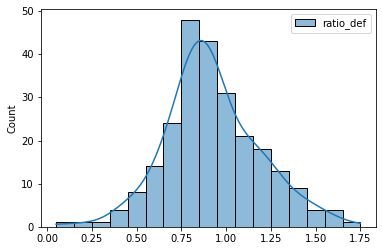

In [15]:
sns.histplot(Y_def,kde=True)
plt.show()

**Distribution Player Efficiency Rating**

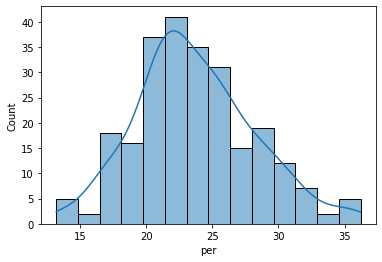

In [16]:
sns.histplot(X['per'],kde=True)
plt.show()

**Distribution minutes played**

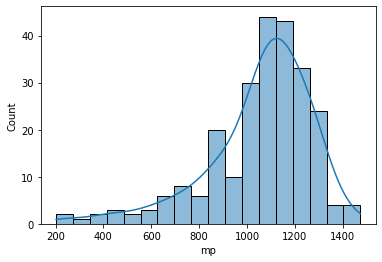

In [17]:
sns.histplot(X['mp'],kde=True)
plt.show()

In [18]:
y_base_train, y_base_test = train_test_split(Y_def, test_size = 0.2, random_state = 0)

In [19]:
baseline_mse = ((y_base_test-y_base_train.mean())**2).mean()[0].round(3)
print(f'La MSE a battre par nos modèle est {baseline_mse}')

La MSE a battre par nos modèle est 0.075


In [20]:
# baseline_mse_full = ((Y_def-Y_def.mean())**2).mean()[0].round(3)
# print(f'La MSE a battre par nos modèles est {baseline_mse_full}')

## KNN model

In [21]:
X.head()

,season,school_name,conf_abbr,g,gs,mp,per,ts_pct,efg_pct,fg3a_per_fga_pct,...,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,obpm,dbpm,years,pos
0,2011-12,Kentucky,SEC,40,40,1281,35.1,0.654,0.628,0.059,...,2.5,13.7,8.6,18.8,5.9,4.1,9.1,8.1,1,PF
1,2011-12,Kentucky,SEC,40,39,1245,21.2,0.570,0.511,0.156,...,1.9,2.8,17.3,20.6,3.4,2.6,4.1,3.6,1,SF
2,2011-12,Florida,SEC,37,37,1267,22.0,0.575,0.525,0.473,...,2.5,2.6,14.3,23.0,3.6,2.1,5.4,2.9,1,SG
3,2011-12,Syracuse,Big East,37,0,891,26.3,0.565,0.534,0.317,...,4.6,1.5,10.4,26.7,3.2,1.7,6.0,4.8,2,SG
4,2011-12,Kansas,Big 12,39,39,1242,27.4,0.549,0.512,0.027,...,2.0,2.9,14.2,30.0,3.7,3.5,5.4,3.4,3,PF


In [22]:
X_knn = X.drop(columns=['school_name','conf_abbr','season'])
X_knn['gs_pct'] = (X_knn['gs']/X_knn['g']).round(2)
X_knn = X_knn.drop(columns=['g','gs'])
X_knn.replace(to_replace=['SF,SG','PG,SG','C,PF'],value=['SF','PG','C'],inplace=True)
X_knn = pd.get_dummies(X_knn)

In [23]:
X_knn.head()

,mp,per,ts_pct,efg_pct,fg3a_per_fga_pct,fta_per_fga_pct,pprod,orb_pct,drb_pct,trb_pct,...,dws,obpm,dbpm,years,gs_pct,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,1281,35.1,0.654,0.628,0.059,0.602,550.0,11.6,25.6,19.0,...,4.1,9.1,8.1,1,1.00,0,1,0,0,0
1,1245,21.2,0.570,0.511,0.156,0.589,497.0,10.3,17.3,14.0,...,2.6,4.1,3.6,1,0.98,0,0,0,1,0
2,1267,22.0,0.575,0.525,0.473,0.440,522.0,4.8,20.3,12.3,...,2.1,5.4,2.9,1,1.00,0,0,0,0,1
3,891,26.3,0.565,0.534,0.317,0.331,430.0,2.4,8.8,5.6,...,1.7,6.0,4.8,2,0.00,0,0,0,0,1
4,1242,27.4,0.549,0.512,0.027,0.462,660.0,11.1,33.0,22.2,...,3.5,5.4,3.4,3,1.00,0,1,0,0,0


In [24]:
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, Y_def, test_size = 0.2, random_state = 0)

In [25]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_knn_train_scaled = mm_scaler.fit_transform(X_knn_train)
X_knn_train_scaled = pd.DataFrame(X_knn_train_scaled)

X_knn_test_scaled = mm_scaler.fit_transform(X_knn_test)
X_knn_test_scaled = pd.DataFrame(X_knn_test_scaled)

In [26]:
X_knn_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.719138,0.726087,0.703518,0.524793,0.000000,0.599190,0.587689,0.596413,0.571429,0.637209,...,0.555556,0.687075,0.543478,0.75,1.00,1.0,0.0,0.0,0.0,0.0
1,0.550124,0.439130,0.542714,0.677686,0.015015,0.565452,0.408827,0.408072,0.393822,0.451163,...,0.361111,0.435374,0.445652,0.50,1.00,1.0,0.0,0.0,0.0,0.0
2,0.734051,0.395652,0.412060,0.446281,0.620120,0.109312,0.499419,0.174888,0.467181,0.344186,...,0.361111,0.571429,0.423913,0.25,1.00,0.0,0.0,0.0,1.0,0.0
3,0.371168,0.465217,0.628141,0.710744,0.000000,0.097166,0.195122,0.569507,0.459459,0.572093,...,0.305556,0.455782,0.608696,0.00,0.46,1.0,0.0,0.0,0.0,0.0
4,0.803645,0.843478,0.874372,0.822314,0.117117,0.411606,0.687573,0.569507,0.814672,0.800000,...,0.444444,0.809524,0.380435,0.00,1.00,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.780447,0.608696,0.728643,0.648760,0.004505,0.654521,0.456446,0.358744,0.586873,0.553488,...,0.750000,0.557823,0.836957,0.75,0.97,1.0,0.0,0.0,0.0,0.0
192,0.821044,0.652174,0.718593,0.677686,0.593093,0.334683,0.666667,0.224215,0.405405,0.372093,...,0.583333,0.775510,0.543478,0.75,0.97,0.0,0.0,0.0,1.0,0.0
193,0.859155,0.534783,0.648241,0.661157,0.558559,0.214575,0.516841,0.340807,0.297297,0.348837,...,0.388889,0.802721,0.315217,0.50,1.00,0.0,1.0,0.0,0.0,0.0
194,0.732394,0.630435,0.517588,0.429752,0.785285,0.369771,0.519164,0.156951,0.548263,0.404651,...,0.527778,0.795918,0.565217,0.25,0.94,0.0,0.0,0.0,0.0,1.0


In [27]:
mse_values = [] #to store mse values for different k
for K in range(170):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    
    #fit the model
    model.fit(X_knn_train_scaled, y_knn_train)
    
     #make prediction on test set
    y_knn_pred=model.predict(X_knn_test_scaled)
    
    #calculate mse
    mse = mean_squared_error(y_knn_test,y_knn_pred) 
    
    #store rmse values
    mse_values.append(mse) 
#     print('MSE value for k= ' , K , 'is:', mse)

In [28]:
min_mse = min(mse_values)
min_index = mse_values.index(min_mse)
min_index + 1

97

In [29]:
best_knn_model = KNeighborsRegressor(n_neighbors = 97)

<AxesSubplot:>

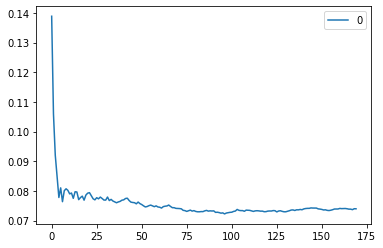

In [30]:
#plotting the rmse values against k values
curve = pd.DataFrame(mse_values) #elbow curve 
curve.plot()

Pas vraiment de résultats probants, tant sur la MSE que sur l'interprétabilité => Explorons la piste de la régression linéaire

## Linear regression

### Simple

In [31]:
X_lin = X.drop(columns=['school_name','conf_abbr','season'])
X_lin['gs_pct'] = (X_lin['gs']/X_lin['g']).round(2)
X_lin = X_lin.drop(columns=['g','gs'])
X_lin.replace(to_replace=['SF,SG','PG,SG','C,PF'],value=['SF','PG','C'],inplace=True)
X_lin = pd.get_dummies(X_lin)

X_train, X_test, y_train, y_test = train_test_split(X_lin, Y_def, test_size = 0.2, random_state = 0)

mm_scaler = MinMaxScaler()

X_lin_scaled = mm_scaler.fit_transform(X_lin)
X_lin_scaled = pd.DataFrame(X_lin_scaled)

X_train_scaled = mm_scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

X_test_scaled = mm_scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

linreg = LinearRegression()

# 5-Fold Cross validate model
cv_results = cross_validate(linreg, X_lin_scaled, Y_def, cv=10, scoring='neg_mean_squared_error')

# Mean of scores
-cv_results['test_score'].mean()


0.06780224917794943

In [33]:
linreg.fit(X_train_scaled,y_train)

LinearRegression()

In [60]:
coef_df = pd.DataFrame(linreg.coef_[0], index=X_lin.columns, columns=['coef'])
coef_df['abs_coef'] = abs(coef_df['coef'])
coef_df.sort_values(by='abs_coef', ascending=False)

,coef,abs_coef
trb_pct,1.083302,1.083302
obpm,0.951474,0.951474
orb_pct,-0.791249,0.791249
efg_pct,0.629479,0.629479
ts_pct,-0.603252,0.603252
per,-0.564195,0.564195
dws,-0.530938,0.530938
drb_pct,-0.521461,0.521461
pprod,-0.390583,0.390583
mp,0.366723,0.366723


In [102]:
to_be_dropped = coef_df.sort_values(by='abs_coef', ascending = False).index[11:]
linreg.intercept_[0]
to_be_dropped

Index(['usg_pct', 'stl_pct', 'ows', 'ast_pct', 'tov_pct', 'blk_pct', 'years',
       'pos_SG', 'fg3a_per_fga_pct', 'pos_PF', 'pos_C', 'gs_pct', 'pos_PG',
       'pos_SF', 'dbpm'],
      dtype='object')

### Drop least important features

In [99]:
X_lin_scaled.columns = X_lin.columns
X_lindrop_scaled = X_lin_scaled.drop(columns=to_be_dropped)

In [100]:
X_lindrop_scaled.head()

,mp,per,ts_pct,efg_pct,fta_per_fga_pct,pprod,orb_pct,drb_pct,trb_pct,dws,obpm
0,0.848270,0.952174,0.784141,0.768061,0.612167,0.552846,0.491150,0.714286,0.688372,1.000000,0.843537
1,0.819969,0.347826,0.414097,0.323194,0.595691,0.491289,0.433628,0.393822,0.455814,0.583333,0.503401
2,0.837264,0.382609,0.436123,0.376426,0.406844,0.520325,0.190265,0.509653,0.376744,0.444444,0.591837
3,0.541667,0.569565,0.392070,0.410646,0.268695,0.413473,0.084071,0.065637,0.065116,0.333333,0.632653
4,0.817610,0.617391,0.321586,0.326996,0.434728,0.680604,0.469027,1.000000,0.837209,0.833333,0.591837


In [256]:
linreg2 = LinearRegression()

# 5-Fold Cross validate model
cv_results = cross_validate(linreg2, X_lindrop_scaled, Y_def, cv=20, scoring='neg_mean_squared_error')

# Mean of scores
-cv_results['test_score'].mean()

0.062006608386601235

### SGD Regression

In [104]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
sgd_model = SGDRegressor()

In [350]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'max_iter': [100000],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(sgd_model, param_grid)


In [351]:
clf.fit(X_train_scaled.values, y_train.values[:,0])
clf.best_score_

/home/malom/.pyenv/versions/3.8.6/envs/nba_forecast/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/malom/.pyenv/versions/3.8.6/envs/nba_forecast/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/malom/.pyenv/versions/3.8.6/envs/nba_forecast/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/malom/.pyenv/versions/3.8.6/envs/nba_for

0.014823908021936626

In [352]:
best_sgd = clf.best_estimator_
best_sgd.fit(X_train_scaled.values, y_train.values[:,0])

SGDRegressor(alpha=0.01, learning_rate='optimal', loss='huber', max_iter=100000)

SGDRegressor(alpha=0.001, early_stopping=True, learning_rate='optimal',
             loss='huber', max_iter=10000, penalty='l1')

In [445]:
# 5-Fold Cross validate model
cv_results = cross_validate(clf.best_estimator_, X_lin_scaled, Y_def.values[:,0], cv=20, scoring='neg_mean_squared_error')

# Mean of scores
-cv_results['test_score'].mean()

0.06335932330536584

### elastic net

In [452]:
# https://www.kaggle.com/residentmario/nyc-buildings-part-2-feature-scales-grid-search
# from sklearn.linear_model import ElasticNet

# clf = GridSearchCV(ElasticNet, {'alpha': [0, 0.5, 0.1, 0.01, 0.001],
#                                 'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
#                    scoring=r2_score)
# clf.fit(normalize(X), 
#         normalize(y[:, np.newaxis]))
# clf.subclf

In [447]:
from sklearn.linear_model import ElasticNetCV
elastic_net = ElasticNetCV(cv=20, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

/home/malom/.pyenv/versions/3.8.6/envs/nba_forecast/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


ElasticNetCV(cv=20, max_iter=10000)

In [451]:
((y_test.values[:,0] - elastic_net.predict(X_test_scaled))**2).mean()

0.0697988679177374

## KMEANS

In [39]:
test_df=uni_data_df.drop(columns=['school_name','conf_abbr'])

In [40]:
test_df = test_df.fillna(-1)

In [41]:
# Fit a K-MEANS
X_proj = test_df.drop(columns=['player_id','player_name', 'season'])
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(X_proj)

KMeans(n_clusters=2)

In [42]:
km.cluster_centers_.shape

(2, 25)

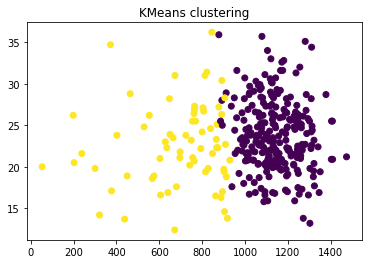

In [43]:
plt.scatter(X_proj.iloc[:,2], X_proj.iloc[:,3], c=km.labels_)
plt.title('KMeans clustering');

In [44]:
len(X_proj.columns)

25

## PCA

In [45]:
#⚠️ Data must be centered around their mean before apply PCA ⚠️
scaler = StandardScaler()
scaler.fit(X_proj)
X_standard = pd.DataFrame(scaler.transform(X_proj), columns=X_proj.columns)
X_standard

,g,gs,mp,per,ts_pct,efg_pct,fg3a_per_fga_pct,fta_per_fga_pct,pprod,orb_pct,...,tov_pct,usg_pct,ows,dws,ws,ws_per_40,obpm,dbpm,bpm,years
0,1.222250,1.034678,1.028759,2.668634,1.730719,1.765677,-1.228678,1.311577,0.387539,1.168637,...,-1.518829,-1.407264,2.060295,3.324383,2.976111,2.628326,1.602427,3.085636,3.106535,-1.200523
1,1.222250,0.919522,0.869182,-0.525581,-0.194696,-0.608936,-0.686537,1.218733,0.020800,0.854210,...,1.061360,-0.974193,0.176016,1.074294,0.583836,0.014986,-0.531586,0.421510,-0.185398,-1.200523
2,0.629465,0.689211,0.966701,-0.341741,-0.080088,-0.324794,1.085202,0.154598,0.193790,-0.476058,...,0.171640,-0.396765,0.326759,0.324264,0.399814,-0.250778,0.023257,0.007090,0.057165,-1.200523
3,0.629465,-3.571552,-0.699996,0.646397,-0.309305,-0.142132,0.213305,-0.623864,-0.442813,-1.056538,...,-0.984997,0.493435,0.025274,-0.275759,-0.029568,0.701541,0.279338,1.131943,0.888812,-0.372063
4,1.024655,0.919522,0.855883,0.899177,-0.676050,-0.588640,-1.407528,0.311718,1.148695,1.047703,...,0.141982,1.287398,0.402130,2.424347,1.319920,0.878717,0.023257,0.303104,0.195773,0.456397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.431870,0.343743,-0.238994,0.485538,-0.240540,0.182602,-1.245445,-0.573871,-0.290582,1.555624,...,-0.065619,-0.420825,-0.577695,0.774282,-0.152249,0.037133,-0.531586,0.717524,-0.012139,0.456397
330,-0.160916,-0.692658,0.066862,0.048918,-0.584364,-0.487161,0.772214,-1.152361,0.899590,0.297916,...,-0.273221,1.527993,-0.426953,0.174258,-0.274930,-0.383660,-0.104784,-1.472980,-0.947741,1.284858
331,-0.160916,0.228588,0.208709,-0.732400,-0.034245,0.223193,0.313909,-1.745135,-0.553527,0.563970,...,-1.518829,-1.671918,-0.276210,-0.275759,-0.336270,-0.649423,-0.360865,-0.940155,-0.843785,1.284858
332,-0.358511,-0.001724,-0.602476,-1.077100,-0.103010,0.020235,1.191395,-1.038092,-0.761115,0.104423,...,0.408899,-0.324587,-1.105293,-0.875783,-1.256376,-1.313832,-0.915709,-0.762546,-1.224956,1.284858


<AxesSubplot:>

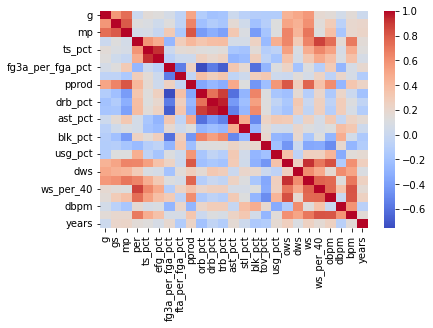

In [46]:
sns.heatmap(pd.DataFrame(X_proj).corr(), cmap='coolwarm')

In [47]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_standard)

PCA()

In [48]:
# Access our 13 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=X_proj.columns,
                 columns=[f'PC{i}' for i in range(1, 26)])
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
g,-0.185304,-0.027307,-0.298539,-0.372359,0.115114,-0.038732,0.162686,0.081917,-0.144937,-0.088570,...,0.487679,-0.046196,0.104057,0.041594,-0.046650,0.048554,-0.058539,-0.003003,-0.004637,0.000083
gs,-0.222292,-0.059323,-0.260954,-0.284309,-0.095161,-0.010312,-0.127828,-0.111546,0.052155,0.303567,...,0.387797,0.027181,-0.060395,0.031724,-0.025652,-0.019083,-0.013181,-0.004023,0.001023,-0.000978
mp,-0.263893,-0.142405,-0.249792,-0.275226,-0.047198,-0.023579,-0.035063,-0.066433,0.073967,0.071872,...,-0.406250,-0.097308,0.191844,-0.086938,0.596446,0.090436,0.319407,-0.010666,0.017967,-0.009062
per,-0.228891,0.267287,0.161131,0.152346,-0.173637,-0.033531,0.016799,-0.036835,-0.125663,0.191360,...,0.156603,-0.083241,0.251415,-0.090086,0.407947,-0.303440,-0.591944,-0.033287,-0.024173,0.004432
ts_pct,-0.176215,0.201573,0.252321,-0.099001,0.291061,-0.364543,-0.069542,-0.047113,0.064815,0.024335,...,0.029574,0.017038,0.015314,-0.597218,-0.064061,0.443561,-0.049751,0.039306,0.006896,-0.000317
efg_pct,-0.112607,0.219993,0.242095,-0.157684,0.345153,-0.312374,-0.105755,-0.207590,-0.026491,0.165787,...,-0.120803,-0.257763,-0.191428,0.533534,0.034023,-0.195096,0.096583,-0.012555,-0.003461,-0.002253
fg3a_per_fga_pct,-0.117218,-0.287620,0.159685,0.050312,0.266358,0.152439,-0.078905,-0.189970,0.097355,-0.210676,...,0.158050,-0.182935,-0.230899,0.058269,0.158120,-0.049625,-0.097546,0.002002,-0.003078,0.000649
fta_per_fga_pct,0.020911,0.190380,-0.135384,0.102806,-0.252207,-0.444084,0.186701,0.538718,0.321530,-0.142353,...,0.005569,-0.203450,-0.054652,0.141878,0.009650,-0.031324,-0.005772,-0.007391,-0.003503,-0.001437
pprod,-0.312550,-0.100556,-0.057273,-0.091033,-0.274728,-0.099793,0.035111,-0.118932,-0.117132,0.068091,...,-0.232527,-0.054516,-0.430682,-0.364049,-0.349927,-0.466443,0.010707,0.003722,-0.003544,0.007390
orb_pct,0.117745,0.347455,-0.001723,-0.118320,-0.150481,0.053953,0.064176,-0.054407,0.139720,0.179498,...,-0.085326,-0.186006,-0.348422,-0.056213,0.150239,0.170371,-0.016333,0.347096,0.035578,-0.007353


In [49]:
X_proj_pca = pca.transform(X_standard)
X_proj_pca = pd.DataFrame(X_proj_pca, columns=[f'PC{i}' for i in range(1, 26)])
X_proj_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,-5.054112,7.264500,-2.448993,-0.022362,2.110584,0.923537,1.587151,0.538809,-0.749382,0.411801,...,-0.405680,-0.328619,0.141602,0.319205,-0.134279,0.172646,-0.257319,-0.030018,0.020764,-0.001361
1,0.105513,0.835457,-2.579295,-1.368876,-0.241135,-0.745711,1.099520,0.074870,0.736659,-0.479668,...,-0.101277,0.394697,0.102285,-0.068997,0.128984,0.057482,-0.046150,-0.009878,0.006014,-0.006689
2,-0.630654,-0.553260,-1.065429,-0.646975,0.317763,0.166198,0.841835,-0.919188,0.717971,-0.247247,...,0.130474,0.197564,0.196490,0.087140,0.147246,0.027075,0.036536,0.062804,0.008341,0.019929
3,-0.445487,-1.084795,0.590643,3.551187,1.676751,0.709117,1.610509,0.858673,-0.359193,0.520790,...,-0.192961,0.112860,0.409269,0.069697,0.219283,0.009352,-0.045897,0.001077,-0.057767,0.006039
4,-1.768888,2.932219,-2.266123,-0.887649,-2.818280,1.451358,-0.804242,-0.887833,0.446698,-0.671914,...,0.024587,0.144819,0.067674,0.048699,-0.164115,-0.014649,0.029590,0.023886,-0.003911,-0.003951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.823200,2.142436,-1.284972,-0.191117,-0.002486,0.909692,-0.609001,-0.261709,0.017400,1.481151,...,0.289885,-0.213781,-0.150151,-0.172371,-0.035437,0.036239,-0.068767,-0.031999,-0.010777,0.001363
330,0.182536,-1.083697,1.054679,-0.393840,-1.732706,1.206279,-1.379350,-0.662861,-0.159300,0.098278,...,-0.229370,-0.547444,-0.131137,-0.248800,-0.215586,-0.053758,0.045603,-0.009770,-0.009144,0.006781
331,1.269981,0.192596,1.021879,-2.396440,0.632996,2.006378,-1.654224,-0.544455,1.190067,-0.256813,...,0.185994,-0.334745,-0.208144,-0.259044,-0.091551,0.043930,0.016609,-0.032692,-0.009929,0.001615
332,2.766997,-0.887091,1.100333,-1.443219,0.160147,0.630711,-2.092107,-0.743430,0.413161,-0.494862,...,0.457063,0.020982,-0.305397,-0.110760,0.043173,-0.016041,-0.146967,-0.001667,-0.007895,-0.022379


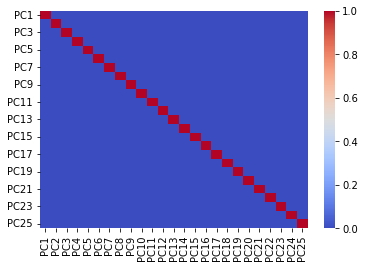

In [50]:
sns.heatmap(X_proj_pca.corr(), cmap='coolwarm');

In [51]:
# Let's compute it
X_proj_pca.std()**2 / ((X_standard.std()**2).sum())

PC1     0.290103
PC2     0.224507
PC3     0.097333
PC4     0.087484
PC5     0.071784
PC6     0.051967
PC7     0.039305
PC8     0.027152
PC9     0.021851
PC10    0.018074
PC11    0.015781
PC12    0.014868
PC13    0.009763
PC14    0.008582
PC15    0.006796
PC16    0.005394
PC17    0.003597
PC18    0.002522
PC19    0.001309
PC20    0.000786
PC21    0.000650
PC22    0.000327
PC23    0.000042
PC24    0.000019
PC25    0.000005
dtype: float64

> 29% of the dataset’s variance lies along the first axis

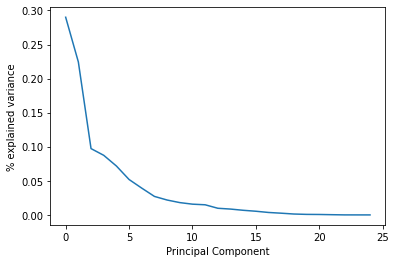

In [52]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

Choose k

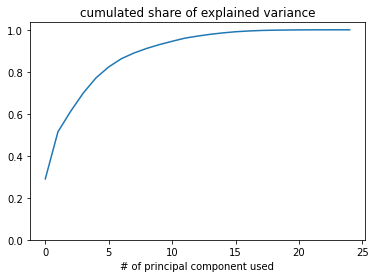

In [53]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [54]:
# Fit a PCA with only 4 components
pca4 = PCA(n_components=4).fit(X_standard)

# Project your data into 4 dimensions
X_proj4 = pd.DataFrame(pca4.fit_transform(X_standard), columns=['PC1', 'PC2', 'PC3','PC4'])

# We have "compressed" our dataset in 3D
X_proj4

,PC1,PC2,PC3,PC4
0,-5.054112,7.264500,-2.448993,-0.022362
1,0.105513,0.835457,-2.579295,-1.368876
2,-0.630654,-0.553260,-1.065429,-0.646975
3,-0.445487,-1.084795,0.590643,3.551187
4,-1.768888,2.932219,-2.266123,-0.887649
...,...,...,...,...
329,0.823200,2.142436,-1.284972,-0.191117
330,0.182536,-1.083697,1.054679,-0.393840
331,1.269981,0.192596,1.021879,-2.396440
332,2.766997,-0.887091,1.100333,-1.443219


In [55]:
pca4.components_
# Print PCs as COLUMNS
W = pd.DataFrame(pca4.components_.T,
                 index=X_proj.columns,
                 columns=[f'PC{i}' for i in range(1, 5)])
W

,PC1,PC2,PC3,PC4
g,-0.185304,-0.027307,-0.298539,-0.372359
gs,-0.222292,-0.059323,-0.260954,-0.284309
mp,-0.263893,-0.142405,-0.249792,-0.275226
per,-0.228891,0.267287,0.161131,0.152346
ts_pct,-0.176215,0.201573,0.252321,-0.099001
efg_pct,-0.112607,0.219993,0.242095,-0.157684
fg3a_per_fga_pct,-0.117218,-0.287620,0.159685,0.050312
fta_per_fga_pct,0.020911,0.190380,-0.135384,0.102806
pprod,-0.312550,-0.100556,-0.057273,-0.091033
orb_pct,0.117745,0.347455,-0.001723,-0.118320
